In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression as mir,SelectKBest

In [2]:
data = pd.read_csv("/home/rajdeep/My_Work/data_science_project/data/Mall_Customers.csv")

###  Basic data exploration

In [3]:
data.shape

(200, 5)

In [4]:
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


#### CustomerID does not have any predictive info, so it can be dropped

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


#### we have 4 numeric features and 1 categorical feature

### Missing Values?

In [6]:
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

#### we do not have any missing values

In [7]:
# How many unique values in Gender?
data.Gender.unique()

array(['Male', 'Female'], dtype=object)

#### Since the number of unique categories in Gender is low, it can be one-hot encoded

In [8]:
data.drop(["CustomerID"], axis=1, inplace=True)
data.rename(columns={"Annual Income (k$)": "Income", "Spending Score (1-100)": "Spending"}, inplace=True)
data.head()

,Gender,Age,Income,Spending
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


## Exploratory Analysis

### What is the distribution of Gender?

<AxesSubplot:>

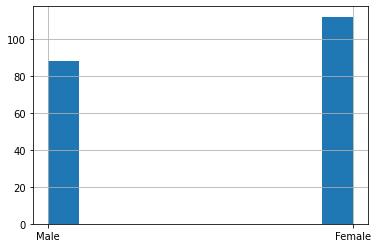

In [9]:
# univariate analysis
data.Gender.hist()

#### There are more number of Female samples in the data than Male

### Which Gender earns more?

In [10]:
data.groupby("Gender").agg({"Income":"mean"})

,Income
Gender,
Female,59.250000
Male,62.227273


#### The average income of Male seems more than Female

### The distribution of the Income

<AxesSubplot:xlabel='Income', ylabel='Count'>

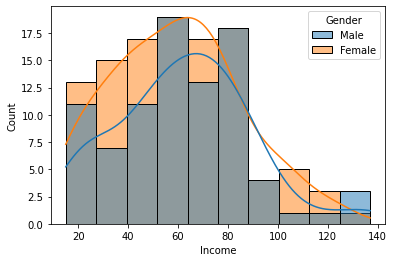

In [11]:
# univariate analysis of income, grouped by gender
sns.histplot(data=data, x="Income", hue="Gender", kde=True)

### Which Gender spends more?

In [12]:
data.groupby("Gender").agg({"Spending":"mean"})

,Spending
Gender,
Female,51.526786
Male,48.511364


#### The average spending of Female seems more than Male

### The distribution of Spending

<AxesSubplot:xlabel='Spending', ylabel='Count'>

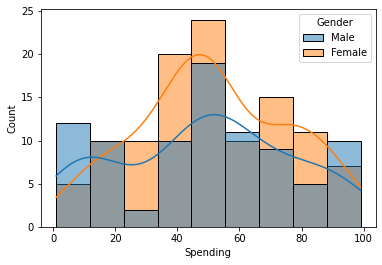

In [13]:
# univariate analysis of Spending, grouped by Gender
sns.histplot(data=data, x="Spending", hue="Gender", kde=True)

### What is the average age of Female visitors and Male Visitors?

In [14]:
data.groupby("Gender").agg({"Age": "mean"})

,Age
Gender,
Female,38.098214
Male,39.806818


#### The average age of Male and Female visitors are similar

### Does the spending habbit vary similarly across all age groups?

<AxesSubplot:xlabel='Age', ylabel='Spending'>

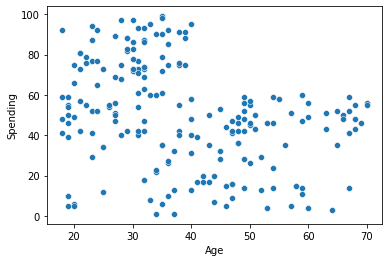

In [15]:
# bivariate analysis of Spending vs Age
sns.scatterplot(data=data, x="Age", y="Spending")

#### People of younger age group, around 20 - 35 tend to spend more

### Is the spending habbit guided by Income?

<AxesSubplot:xlabel='Income', ylabel='Spending'>

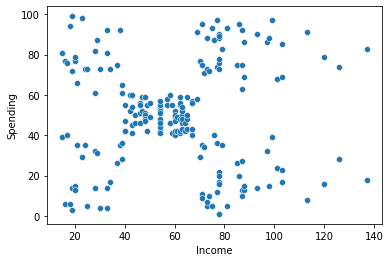

In [16]:
# bivariate analysis of Spending vs Income
sns.scatterplot(data=data, x="Income", y="Spending")

#### We can see some clusters getting formed here:
#### For the low income range, there are 2 clusters
#### For the mid-income range, there is a single cluster
#### For the higher income range, there are 2 clusters

### What are the factors that contribute to this clustering?

#### Is it age?
#### Let's convert Age into a categorical Variable just for the purpose of this analysis

In [17]:
age_category = pd.cut(data.Age, bins=[17,30,50,71], labels=["Young", "Mid", "Aged"])

In [18]:
data.insert(4, "Age_Group", age_category)

In [19]:
data.head()

,Gender,Age,Income,Spending,Age_Group
0,Male,19,15,39,Young
1,Male,21,15,81,Young
2,Female,20,16,6,Young
3,Female,23,16,77,Young
4,Female,31,17,40,Mid


<AxesSubplot:xlabel='Income', ylabel='Spending'>

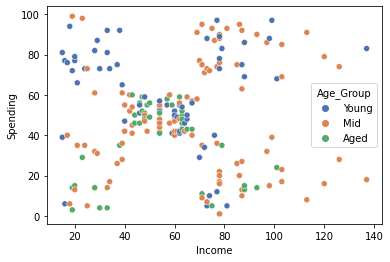

In [20]:
sns.scatterplot(data=data, x="Income", y="Spending", hue="Age_Group", palette="deep")

#### Interestingly, for young age group, people spend very high even with lower income. 
#### Aged people spend less, Young People Spend more

### Are there more female than male in younger age groups?

<AxesSubplot:xlabel='Age_Group'>

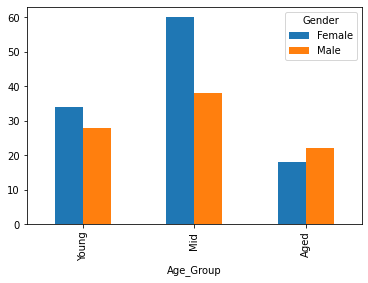

In [21]:
pd.crosstab(data['Age_Group'], data['Gender']).plot(kind='bar', stacked=False)

### Exploratory Analysis Inferences:
1. The number of Young and mid-aged female visitors are more than male visitors. But there are more aged male visitors than aged female visitors.

2. Female visitors on average spend more than male visitors

3. Young visitors have lower income but they spend more, aged visitors spend less irrespective of income

## Data preparation and Modelling

### First let's check for correlation

In [33]:
corr_data = data.drop("Age_Group", axis=1)
corr_data = pd.get_dummies(corr_data, "Gender", drop_first=True)
corr_data.corr()

,Age,Income,Spending,Gender_Male
Age,1.000000,-0.012398,-0.327227,0.060867
Income,-0.012398,1.000000,0.009903,0.056410
Spending,-0.327227,0.009903,1.000000,-0.058109
Gender_Male,0.060867,0.056410,-0.058109,1.000000


1. Age and Spending are negatively correlated
2. Income and Spending do not have any evident correlation, which is probably because they are not linearly correlated
3. Gender Male seems to have a very slight negative correlation with Spending
### We can now experiment with Other Techniques to determine feature importances

### Mutual Information

In [23]:
data_mi = data.copy()

In [24]:
data_mi.head()
data_mi.drop("Age_Group", axis=1, inplace=True)
data_mi=pd.get_dummies(data_mi, "Gender", drop_first=True)
data_mi.head()

,Age,Income,Spending,Gender_Male
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


In [25]:
data_x = data_mi.drop("Spending", axis=1)

In [26]:
data_y = data_mi["Spending"]

In [34]:
# mi_score = mir(data_x, data_y, discrete_features=True)
sf = SelectKBest(score_func=mir, k="all")
sf.fit(data_x, data_y)
print(data_x.columns)
print(sf.scores_)

Index(['Age', 'Income', 'Gender_Male'], dtype='object')
[0.17137611 0.12764803 0.08796825]


#### Age and Income are imore mportant features to determine spending